### Output plume_scene and infrastructure location tables for the SI. 

In [1]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import mine_emis
import utils

In [2]:
PLUMES_PER_SCENE = "../data/kelly_plumes_20250211/radial_MAD_alpha_no_QC/plumes_per_scene.csv" 
PLUMES_PER_SCENE_QC = "../data/kelly_plumes_20250211/radial_MAD_alpha/plumes_per_scene.csv" 
VENT_FILE = '../data/labeled_vents.kml'
LUT = '../data/facility_lookup.csv'
QC_FILE = "../data/plume_qc_new_20250217.csv"
MISSING_FILE = "../data/missing_plume_check.csv"

In [3]:
infra = utils.read_infrastructure_file(VENT_FILE)
pps = pd.read_csv(PLUMES_PER_SCENE)
pps_qc = pd.read_csv(PLUMES_PER_SCENE_QC)

In [4]:
infra.loc[infra.vent_type.isin(['Well', 'Ventilation Shaft']),['vent_id', 'mine', 'vent_type', 'lat', 'lon']
          ].reset_index(drop=True).to_csv("../data/tables_for_SI/infrastructure.csv", index=False)

In [5]:
def apply_qc_to_plume_scene_no_dropping(plumes_per_scene, 
                            qc_filepath, 
                            missing_filepath
                            ):
    missing = pd.read_csv(missing_filepath, dtype={"vent_id":int})
    qc = pd.read_csv(qc_filepath)
    plumes_per_scene = plumes_per_scene[~plumes_per_scene.scene_id.str.contains("emi")] # drop EMIT

    missing = missing[missing.qc.isin(["none","nondetect"])] # all other plumes MUST be handled by QC
    plumes_per_scene = pd.merge(plumes_per_scene, missing[['scene_id', 'vent_id', 'qc']], on=["scene_id", "vent_id"], how='left')
    plumes_per_scene = pd.merge(plumes_per_scene, qc[['plume_id', 'qc']], on='plume_id', how='left', suffixes=('_missing', '_qc'))
    plumes_per_scene['qc'] = plumes_per_scene.qc_qc.combine_first(plumes_per_scene.qc_missing) # if plume is not in QC df, use assessemnt from Missing df

    assert not plumes_per_scene.qc.isnull().any(), "nans present in QC files, finish QC'ing and try again."
    print("QC summary:")
    print(plumes_per_scene.qc.value_counts())

    plumes_per_scene["qc"] = plumes_per_scene.qc.replace({"nondetect": "hide", 
                                                "none": "fail", 
                                                }) # standardize QC names

    plumes_per_scene.loc[plumes_per_scene.qc=='fail','emission_auto'] = 0. # set fail to 0 - no emissions observed.
    plumes_per_scene.loc[(plumes_per_scene.qc=='fail')&
                    ((plumes_per_scene.scene_id.str.contains('ang'))|
                    (plumes_per_scene.scene_id.str.contains('GAO'))), 
                    'emission_uncertainty_auto'] = 50. # set error to upper level 90% POD
    plumes_per_scene['date'] = pd.to_datetime(plumes_per_scene['date'])
        
    return plumes_per_scene

In [6]:
pps_qc['plume_id'].str.split('-')

0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                   ...             
643                             NaN
644                             NaN
645                             NaN
646    [GAO20210515t144158p0000, A]
647    [GAO20210514t132657p0000, 1]
Name: plume_id, Length: 648, dtype: object

In [7]:
pps = pps[pps.scene_id.apply(lambda x: x[0:3] != 'emi')]
pps_qc = apply_qc_to_plume_scene_no_dropping(pps, QC_FILE, MISSING_FILE)
# round emission_auto and emission_uncertainty_auto to 2 decimal places
pps_qc['emission_auto'] = pps_qc['emission_auto'].round(0)
pps_qc['emission_uncertainty_auto'] = pps_qc['emission_uncertainty_auto'].round(0)
pps_qc['plume_label'] = pps_qc['plume_id'].str.split('-').apply(lambda x: x[1] if type(x)==list else x)
pps_qc['vent_id'] = pps_qc['vent_id'].astype(int)
pps_qc.loc[(pps_qc['observed'])&(pps_qc.vent_id.isin(infra[infra.vent_type.isin(['Well', 'Ventilation Shaft'])].vent_id)),
        ['vent_id', 'scene_id', 'plume_label', 'plume_latitude','plume_longitude', 'emission_auto', 'emission_uncertainty_auto',
         'qc_qc']
        ].rename({'qc_qc':'qc'}).reset_index(drop=True).to_csv("../data/tables_for_SI/CM_plumes.csv", index=False)

QC summary:
qc
none         330
pass         264
hide          49
nondetect     43
Name: count, dtype: int64


In [15]:
pps_qc['quarter'] = pps_qc['date'].dt.to_period('Q').astype(str)

array([[<Axes: title={'center': 'scene_id'}>]], dtype=object)

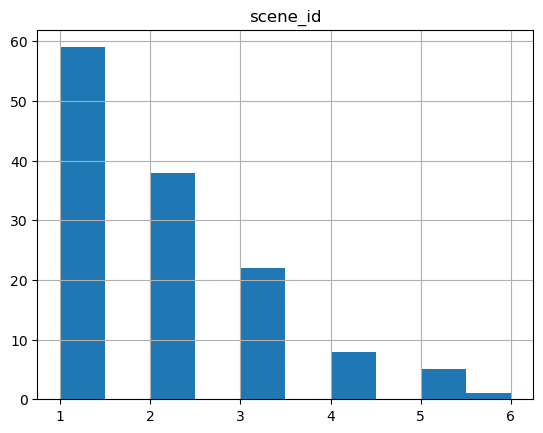

In [17]:
pps_qc[pps_qc.qc_qc.isin(['pass'])].groupby(['vent_id','quarter']).count()[['scene_id']].hist()

In [31]:
(pps_qc[pps_qc.qc_qc.isin(['pass'])].groupby(['vent_id','quarter']).count()[['scene_id']]).value_counts()

scene_id
1           59
2           38
3           22
4            8
5            5
6            1
Name: count, dtype: int64

In [29]:
pps_qc[pps_qc.qc_qc.isin(['pass'])].groupby(['vent_id','quarter'])['emission_auto'].mean().groupby('vent_id').count().value_counts()

emission_auto
1    67
2    24
3     6
Name: count, dtype: int64